In [23]:
require 'cutorch';
require 'cunn';
require 'nn';
require 'model';
require 'mnist_loader';
Plot = require 'itorch.Plot';

In [24]:
cutorch.setDevice(2)

G, D = get_model()
G:cuda()
D:cuda()

criterion = nn.ClassNLLCriterion()
criterion = criterion:cuda()

<mnist> done	


-0.79992614568285	


0.55043469725165	


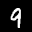

0	


In [25]:
train_set = mnist.loadTrainSet()
print(train_set.data:mean())
print(train_set.data:std())
displayData = train_set[1][1]
itorch.image(displayData)
print(train_set[1][2][9])

In [26]:
fixedLabelVector = torch.zeros(10, 10):cuda()
for m=1, 10 do
    fixedLabelVector[{m, m}] = 1
end
fixedNoise = torch.randn(10, 100):cuda()

In [27]:
G_parameters, G_gradParameters = G:getParameters()
D_parameters, D_gradParameters = D:getParameters()

print(G_parameters:mean())
print(G_parameters:std())
print(D_parameters:mean())
print(D_parameters:std())

0.00057055917568505	
0.030450699850917	
0.00016162832616828	
0.023453362286091	


## arguments for adam optimizer

In [28]:
-- gradclip = 5
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
eps = 10e-8
batchsize = 128
epochsize = 10
counter = 1

counter_tb = {}
D_fake_loss_tb = {}
D_real_loss_tb = {}
G_loss_tb = {}
D_loss_tb = {}

G_m = torch.zeros(G_parameters:size()):cuda()
G_mt = torch.zeros(G_parameters:size()):cuda()
G_v = torch.zeros(G_parameters:size()):cuda()
G_vt = torch.zeros(G_parameters:size()):cuda()

D_m = torch.zeros(D_parameters:size()):cuda()
D_mt = torch.zeros(D_parameters:size()):cuda()
D_v = torch.zeros(D_parameters:size()):cuda()
D_vt = torch.zeros(D_parameters:size()):cuda()

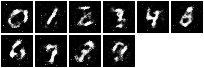

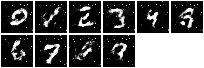

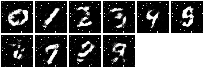

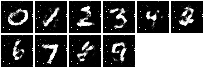

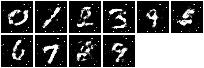

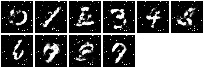

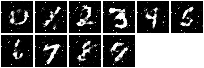

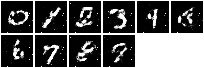

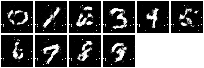

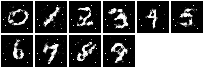

In [29]:
inputImgInputBatch = torch.zeros(batchsize, 32, 32):cuda()        
inputVectorInputBatch = torch.zeros(batchsize, 10):cuda()
inputVectorInputBatchRand = torch.zeros(batchsize, 10):cuda()

for epoch=1, epochsize do
    train_set:shuffle()
    
    if epoch == 30 then
        lr = lr / 10
    end
    if epoch == 40 then
        lr = lr / 10
    end
    
    for batch_count = 1, train_set:size() / batchsize do        
        inputImgInputBatch:zero()
        inputVectorInputBatch:zero()
        for batch_count_idx = 1, batchsize do
            i = (batch_count - 1) * batchsize + batch_count_idx
            inputImgInput = train_set[i][1]:view(32, 32):cuda()
            inputVectorInput = train_set[i][2]:cuda()
            inputVectorInputBatch[batch_count_idx] = inputVectorInput
            inputImgInputBatch[batch_count_idx] = inputImgInput
        end    
        
        
        -- backward discriminator with real image
        realPredBatch = D:forward({inputImgInputBatch, inputVectorInputBatch})
        real_target = 1
        D_backward = torch.zeros(batchsize, 2):cuda()        
        D_real_loss_total = 0
        for batch_count_idx = 1, batchsize do
            D_real_loss = criterion:forward(realPredBatch[batch_count_idx], real_target)            
            D_real_loss_total = D_real_loss_total + D_real_loss            
            D_criterion = criterion:backward(realPredBatch[batch_count_idx], real_target)                       
            D_backward[batch_count_idx] = D_criterion                        
        end        
        D_real_loss_total = D_real_loss_total / batchsize
        D:zeroGradParameters()
        D:backward({inputImgInputBatch, inputVectorInputBatch}, D_backward)        
        D_gradParameters:div(batchsize)

        -- remember grad parameters
        D_gradParametersReal = D_gradParameters:clone()        
            
        -- backward discriminator with fake image
        inputVectorInputBatchRand:zero()
        for i = 1, batchsize do
            inputVectorInputBatchRand[i][torch.random(1,10)] = 1
        end
        noiseBatch = torch.randn(batchsize, 100):cuda()
        fakeImgBatch = G:forward({noiseBatch, inputVectorInputBatchRand})                
        fakePredBatch = D:forward({fakeImgBatch, inputVectorInputBatchRand})
        fake_target = 2
        D_backward = torch.zeros(batchsize, 2):cuda()
        D_fake_loss_total = 0
        for batch_count_idx = 1, batchsize do
            D_fake_loss = criterion:forward(fakePredBatch[batch_count_idx], fake_target)
            D_fake_loss_total = D_fake_loss_total + D_fake_loss
            D_criterion = criterion:backward(fakePredBatch[batch_count_idx], fake_target)
            D_backward[{{batch_count_idx}, {}}] = D_criterion:clone()
        end
        D_fake_loss_total = D_fake_loss_total / batchsize
        D:zeroGradParameters()
        fakeImgPrime = D:backward({fakeImgBatch, inputVectorInputBatchRand}, D_backward)        
        
        D_gradParameters:div(batchsize)
        
        -- add grad parameter from real image backward
        D_gradParameters:add(D_gradParametersReal)
        
        
        -- update D parameters with Adam optimizer
        D_m:mul(beta1):add(torch.mul(D_gradParameters, 1-beta1))
        D_v:mul(beta2):add(torch.mul(torch.pow(D_gradParameters, 2), 1-beta2))

        -- correct m and v
        D_mt:copy(torch.div(D_m, 1-math.pow(beta1, counter)))
        D_vt:copy(torch.div(D_v, 1-math.pow(beta2, counter)))

        D_vt:sqrt():add(eps)
        D_mt:mul(-1*lr)
        D_parameters:add(D_mt:cdiv(D_vt))

        
        
        -- training generator
        inputVectorInputBatchRand:zero()
        for i = 1, batchsize do
            inputVectorInputBatchRand[i][torch.random(1,10)] = 1
        end
        noiseBatch = torch.randn(batchsize, 100):cuda()
        fakeImgBatch = G:forward({noiseBatch, inputVectorInputBatchRand})                
        fakePredBatch = D:forward({fakeImgBatch, inputVectorInputBatchRand})
        D_backward = torch.zeros(batchsize, 2):cuda()
        
        G_loss_total = 0
        for batch_count_idx = 1, batchsize do
            G_loss = criterion:forward(fakePredBatch[batch_count_idx], real_target)
            G_loss_total = G_loss_total + G_loss
            D_criterion = criterion:backward(fakePredBatch[batch_count_idx], real_target)
            D_backward[{{batch_count_idx}, {}}] = D_criterion:clone()
        end
        G_loss_total = G_loss_total / batchsize
        D:zeroGradParameters()
        fakeImgPrime = D:backward({fakeImgBatch, inputVectorInputBatchRand}, D_backward)                                        
        
        G:zeroGradParameters()
        G:backward({noiseBatch, inputVectorInputBatchRand}, fakeImgPrime[1])
        G_gradParameters:div(batchsize)

        -- update generator parameter with Adam optimizer
        G_m:mul(beta1):add(torch.mul(G_gradParameters, 1-beta1))
        G_v:mul(beta2):add(torch.mul(torch.pow(G_gradParameters, 2), 1-beta2))

        -- correct m and v
        G_mt:copy(torch.div(G_m, 1-math.pow(beta1, counter)))
        G_vt:copy(torch.div(G_v, 1-math.pow(beta2, counter)))

        G_vt:sqrt():add(eps)
        G_mt:mul(-1*lr)
        G_parameters:add(G_mt:cdiv(G_vt))
 
        counter = counter + 1        
        if counter % 100 == 0 then            
            table.insert(counter_tb, counter)
            table.insert(D_fake_loss_tb, D_fake_loss_total)
            table.insert(D_real_loss_tb, D_real_loss_total)
            table.insert(G_loss_tb, G_loss_total)
            table.insert(D_loss_tb, D_fake_loss_total + D_real_loss_total)
        end
    end
    local res = G:forward({fixedNoise, fixedLabelVector}) + 0.5
    itorch.image(res)
end

In [30]:
plot = Plot():line(counter_tb, D_loss_tb, "blue", "D loss")
-- plot:line(counter_tb, D_fake_loss_tb, "green", "D fake loss")
-- plot:line(counter_tb, D_real_loss_tb, "black", "D real loss")
plot:line(counter_tb, G_loss_tb, "orange", "G loss")
plot:title("gan training loss plot")
plot:draw()
plot:save("gan_training_loss_plot.html")

## debug part

 1  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1
[torch.CudaTensor of size 10x10]



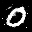

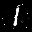

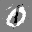

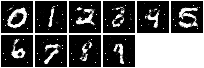

In [31]:
labelVector = torch.zeros(10, 10):cuda()
            
for m=1, 10 do
    labelVector[{m, m}] = 1
end
print(labelVector)
noise = torch.randn(10, 100):cuda()

local res = G:forward({noise, labelVector}) + 0.5
itorch.image(res[1])
itorch.image(res[2])
print(itorch.image(res[1] - res[2]))
itorch.image(res)